In [1]:
# imports
import argparse
import logging
import sys
import os
from configparser import ConfigParser

from torch import optim


import subprocess
import os
import abc
import hashlib
import zipfile
import glob
import logging
import tarfile
from skimage.io import imread
from PIL import Image
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [2]:

from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)

CONFIG_FILE = "hyperparam.ini"
RES_DIR = "results"

c:\Users\atoma\OneDrive\Área de Trabalho\Machine-LEarn\join_notebook\utils


# MATH

In [3]:

import math

from tqdm import trange, tqdm
import torch


def matrix_log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian for all combination of bacth pairs of
    `x` and `mu`. I.e. return tensor of shape `(batch_size, batch_size, dim)`
    instead of (batch_size, dim) in the usual log density.

    Parameters
    ----------
    x: torch.Tensor
        Value at which to compute the density. Shape: (batch_size, dim).

    mu: torch.Tensor
        Mean. Shape: (batch_size, dim).

    logvar: torch.Tensor
        Log variance. Shape: (batch_size, dim).

    batch_size: int
        number of training images in the batch
    """
    batch_size, dim = x.shape
    x = x.view(batch_size, 1, dim)
    mu = mu.view(1, batch_size, dim)
    logvar = logvar.view(1, batch_size, dim)
    return log_density_gaussian(x, mu, logvar)


def log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian.

    Parameters
    ----------
    x: torch.Tensor or np.ndarray or float
        Value at which to compute the density.

    mu: torch.Tensor or np.ndarray or float
        Mean.

    logvar: torch.Tensor or np.ndarray or float
        Log variance.
    """
    normalization = - 0.5 * (math.log(2 * math.pi) + logvar)
    inv_var = torch.exp(-logvar)
    log_density = normalization - 0.5 * ((x - mu)**2 * inv_var)
    return log_density


def log_importance_weight_matrix(batch_size, dataset_size):
    """
    Calculates a log importance weight matrix

    Parameters
    ----------
    batch_size: int
        number of training images in the batch

    dataset_size: int
    number of training images in the dataset
    """
    N = dataset_size
    M = batch_size - 1
    strat_weight = (N - M) / (N * M)
    W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
    W.view(-1)[::M + 1] = 1 / N
    W.view(-1)[1::M + 1] = strat_weight
    W[M - 1, 0] = strat_weight
    return W.log()


# INIT


In [4]:
import torch
from torch import nn


def get_activation_name(activation):
    """Given a string or a `torch.nn.modules.activation` return the name of the activation."""
    if isinstance(activation, str):
        return activation

    mapper = {nn.LeakyReLU: "leaky_relu", nn.ReLU: "relu", nn.Tanh: "tanh",
              nn.Sigmoid: "sigmoid", nn.Softmax: "sigmoid"}
    for k, v in mapper.items():
        if isinstance(activation, k):
            return k

    raise ValueError("Unkown given activation type : {}".format(activation))


def get_gain(activation):
    """Given an object of `torch.nn.modules.activation` or an activation name
    return the correct gain."""
    if activation is None:
        return 1

    activation_name = get_activation_name(activation)

    param = None if activation_name != "leaky_relu" else activation.negative_slope
    gain = nn.init.calculate_gain(activation_name, param)

    return gain


def linear_init(layer, activation="relu"):
    """Initialize a linear layer.
    Args:
        layer (nn.Linear): parameters to initialize.
        activation (`torch.nn.modules.activation` or str, optional) activation that
            will be used on the `layer`.
    """
    x = layer.weight

    if activation is None:
        return nn.init.xavier_uniform_(x)

    activation_name = get_activation_name(activation)

    if activation_name == "leaky_relu":
        a = 0 if isinstance(activation, str) else activation.negative_slope
        return nn.init.kaiming_uniform_(x, a=a, nonlinearity='leaky_relu')
    elif activation_name == "relu":
        return nn.init.kaiming_uniform_(x, nonlinearity='relu')
    elif activation_name in ["sigmoid", "tanh"]:
        return nn.init.xavier_uniform_(x, gain=get_gain(activation))


def weights_init(module):
    if isinstance(module, torch.nn.modules.conv._ConvNd):
        # TO-DO: check litterature
        linear_init(module)
    elif isinstance(module, nn.Linear):
        linear_init(module)


# ModelIO

In [5]:
import json
import os
import re

import numpy as np
import torch


MODEL_FILENAME = "model.pt"
META_FILENAME = "specs.json"


def save_model(model, directory, metadata=None, filename=MODEL_FILENAME):
    """
    Save a model and corresponding metadata.

    Parameters
    ----------
    model : nn.Module
        Model.

    directory : str
        Path to the directory where to save the data.

    metadata : dict
        Metadata to save.
    """
    device = next(model.parameters()).device
    model.cpu()

    if metadata is None:
        # save the minimum required for loading
        metadata = dict(img_size=model.img_size, latent_dim=model.latent_dim,
                        model_type=model.model_type)

    save_metadata(metadata, directory)

    path_to_model = os.path.join(directory, filename)
    torch.save(model.state_dict(), path_to_model)

    model.to(device)  # restore device


def load_metadata(directory, filename=META_FILENAME):
    """Load the metadata of a training directory.

    Parameters
    ----------
    directory : string
        Path to folder where model is saved. For example './experiments/mnist'.
    """
    path_to_metadata = os.path.join(directory, filename)

    with open(path_to_metadata) as metadata_file:
        metadata = json.load(metadata_file)

    return metadata


def save_metadata(metadata, directory, filename=META_FILENAME, **kwargs):
    """Load the metadata of a training directory.

    Parameters
    ----------
    metadata:
        Object to save

    directory: string
        Path to folder where to save model. For example './experiments/mnist'.

    kwargs:
        Additional arguments to `json.dump`
    """
    path_to_metadata = os.path.join(directory, filename)

    with open(path_to_metadata, 'w') as f:
        json.dump(metadata, f, indent=4, sort_keys=True, **kwargs)


def load_model(directory, is_gpu=True, filename=MODEL_FILENAME):
    """Load a trained model.

    Parameters
    ----------
    directory : string
        Path to folder where model is saved. For example './experiments/mnist'.

    is_gpu : bool
        Whether to load on GPU is available.
    """
    device = torch.device("cuda" if torch.cuda.is_available() and is_gpu
                          else "cpu")

    path_to_model = os.path.join(directory, MODEL_FILENAME)

    metadata = load_metadata(directory)
    img_size = metadata["img_size"]
    latent_dim = metadata["latent_dim"]
    model_type = metadata["model_type"]

    path_to_model = os.path.join(directory, filename)
    model = _get_model(model_type, img_size, latent_dim, device, path_to_model)
    return model


def load_checkpoints(directory, is_gpu=True):
    """Load all chechpointed models.

    Parameters
    ----------
    directory : string
        Path to folder where model is saved. For example './experiments/mnist'.

    is_gpu : bool
        Whether to load on GPU .
    """
    checkpoints = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            results = re.search(r'.*?-([0-9].*?).pt', filename)
            if results is not None:
                epoch_idx = int(results.group(1))
                model = load_model(root, is_gpu=is_gpu, filename=filename)
                checkpoints.append((epoch_idx, model))

    return checkpoints


def _get_model(model_type, img_size, latent_dim, device, path_to_model):
    """ Load a single model.

    Parameters
    ----------
    model_type : str
        The name of the model to load. For example Burgess.
    img_size : tuple
        Tuple of the number of pixels in the image width and height.
        For example (32, 32) or (64, 64).
    latent_dim : int
        The number of latent dimensions in the bottleneck.

    device : str
        Either 'cuda' or 'cpu'
    path_to_device : str
        Full path to the saved model on the device.
    """
    model = init_specific_model(model_type, img_size, latent_dim).to(device)
    # works with state_dict to make it independent of the file structure
    model.load_state_dict(torch.load(path_to_model), strict=False)
    model.eval()

    return model


def numpy_serialize(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))


def save_np_arrays(arrays, directory, filename):
    """Save dictionary of arrays in json file."""
    save_metadata(arrays, directory, filename=filename, default=numpy_serialize)


def load_np_arrays(directory, filename):
    """Load dictionary of arrays from json file."""
    arrays = load_metadata(directory, filename=filename)
    return {k: np.array(v) for k, v in arrays.items()}


# LOSS

In [6]:
"""
Module containing all vae losses.
"""
import abc
import math

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim


LOSSES = ["VAE", "betaH", "betaB", "factor", "btcvae"]
RECON_DIST = ["bernoulli", "laplace", "gaussian"]


# TO-DO: clean n_data and device
def get_loss_f(loss_name, **kwargs_parse):
    """Return the correct loss function given the argparse arguments."""
    kwargs_all = dict(rec_dist=kwargs_parse["rec_dist"],
                      steps_anneal=kwargs_parse["reg_anneal"])
    if loss_name == "betaH":
        return BetaHLoss(beta=kwargs_parse["betaH_B"], **kwargs_all)
    elif loss_name == "VAE":
        return BetaHLoss(beta=1, **kwargs_all)
    elif loss_name == "betaB":
        return BetaBLoss(C_init=kwargs_parse["betaB_initC"],
                         C_fin=kwargs_parse["betaB_finC"],
                         gamma=kwargs_parse["betaB_G"],
                         **kwargs_all)

    else:
        assert loss_name not in LOSSES
        raise ValueError("Uknown loss : {}".format(loss_name))


class BaseLoss(abc.ABC):
    """
    Base class for losses.

    Parameters
    ----------
    record_loss_every: int, optional
        Every how many steps to recorsd the loss.

    rec_dist: {"bernoulli", "gaussian", "laplace"}, optional
        Reconstruction distribution istribution of the likelihood on the each pixel.
        Implicitely defines the reconstruction loss. Bernoulli corresponds to a
        binary cross entropy (bse), Gaussian corresponds to MSE, Laplace
        corresponds to L1.

    steps_anneal: nool, optional
        Number of annealing steps where gradually adding the regularisation.
    """

    def __init__(self, record_loss_every=50, rec_dist="bernoulli", steps_anneal=0):
        self.n_train_steps = 0
        self.record_loss_every = record_loss_every
        self.rec_dist = rec_dist
        self.steps_anneal = steps_anneal

    @abc.abstractmethod
    def __call__(self, data, recon_data, latent_dist, is_train, storer, **kwargs):
        """
        Calculates loss for a batch of data.

        Parameters
        ----------
        data : torch.Tensor
            Input data (e.g. batch of images). Shape : (batch_size, n_chan,
            height, width).

        recon_data : torch.Tensor
            Reconstructed data. Shape : (batch_size, n_chan, height, width).

        latent_dist : tuple of torch.tensor
            sufficient statistics of the latent dimension. E.g. for gaussian
            (mean, log_var) each of shape : (batch_size, latent_dim).

        is_train : bool
            Whether currently in train mode.

        storer : dict
            Dictionary in which to store important variables for vizualisation.

        kwargs:
            Loss specific arguments
        """

    def _pre_call(self, is_train, storer):
        if is_train:
            self.n_train_steps += 1

        if not is_train or self.n_train_steps % self.record_loss_every == 1:
            storer = storer
        else:
            storer = None

        return storer


class BetaHLoss(BaseLoss):
    """
    Compute the Beta-VAE loss as in [1]

    Parameters
    ----------
    beta : float, optional
        Weight of the kl divergence.

    kwargs:
        Additional arguments for `BaseLoss`, e.g. rec_dist`.

    References
    ----------
        [1] Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with
        a constrained variational framework." (2016).
    """

    def __init__(self, beta=4, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def __call__(self, data, recon_data, latent_dist, is_train, storer, **kwargs):
        storer = self._pre_call(is_train, storer)

        rec_loss = _reconstruction_loss(data, recon_data,
                                        storer=storer,
                                        distribution=self.rec_dist)
        kl_loss = _kl_normal_loss(*latent_dist, storer)
        anneal_reg = (linear_annealing(0, 1, self.n_train_steps, self.steps_anneal)
                      if is_train else 1)
        loss = rec_loss + anneal_reg * (self.beta * kl_loss)

        if storer is not None:
            storer['loss'].append(loss.item())

        return loss


class BetaBLoss(BaseLoss):
    """
    Compute the Beta-VAE loss as in [1]

    Parameters
    ----------
    C_init : float, optional
        Starting annealed capacity C.

    C_fin : float, optional
        Final annealed capacity C.

    gamma : float, optional
        Weight of the KL divergence term.

    kwargs:
        Additional arguments for `BaseLoss`, e.g. rec_dist`.

    References
    ----------
        [1] Burgess, Christopher P., et al. "Understanding disentangling in
        $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """

    def __init__(self, C_init=0., C_fin=20., gamma=100., **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.C_init = C_init
        self.C_fin = C_fin

    def __call__(self, data, recon_data, latent_dist, is_train, storer, **kwargs):
        storer = self._pre_call(is_train, storer)

        rec_loss = _reconstruction_loss(data, recon_data,
                                        storer=storer,
                                        distribution=self.rec_dist)
        kl_loss = _kl_normal_loss(*latent_dist, storer)

        C = (linear_annealing(self.C_init, self.C_fin, self.n_train_steps, self.steps_anneal)
             if is_train else self.C_fin)

        loss = rec_loss + self.gamma * (kl_loss - C).abs()

        if storer is not None:
            storer['loss'].append(loss.item())

        return loss



def _reconstruction_loss(data, recon_data, distribution="bernoulli", storer=None):
    """
    Calculates the per image reconstruction loss for a batch of data. I.e. negative
    log likelihood.

    Parameters
    ----------
    data : torch.Tensor
        Input data (e.g. batch of images). Shape : (batch_size, n_chan,
        height, width).

    recon_data : torch.Tensor
        Reconstructed data. Shape : (batch_size, n_chan, height, width).

    distribution : {"bernoulli", "gaussian", "laplace"}
        Distribution of the likelihood on the each pixel. Implicitely defines the
        loss Bernoulli corresponds to a binary cross entropy (bse) loss and is the
        most commonly used. It has the issue that it doesn't penalize the same
        way (0.1,0.2) and (0.4,0.5), which might not be optimal. Gaussian
        distribution corresponds to MSE, and is sometimes used, but hard to train
        ecause it ends up focusing only a few pixels that are very wrong. Laplace
        distribution corresponds to L1 solves partially the issue of MSE.

    storer : dict
        Dictionary in which to store important variables for vizualisation.

    Returns
    -------
    loss : torch.Tensor
        Per image cross entropy (i.e. normalized per batch but not pixel and
        channel)
    """
    batch_size, n_chan, height, width = recon_data.size()
    is_colored = n_chan == 3

    if distribution == "bernoulli":
        loss = F.binary_cross_entropy(recon_data, data, reduction="sum")
    elif distribution == "gaussian":
        # loss in [0,255] space but normalized by 255 to not be too big
        loss = F.mse_loss(recon_data * 255, data * 255, reduction="sum") / 255
    elif distribution == "laplace":
        # loss in [0,255] space but normalized by 255 to not be too big but
        # multiply by 255 and divide 255, is the same as not doing anything for L1
        loss = F.l1_loss(recon_data, data, reduction="sum")
        loss = loss * 3  # emperical value to give similar values than bernoulli => use same hyperparam
        loss = loss * (loss != 0)  # masking to avoid nan
    else:
        assert distribution not in RECON_DIST
        raise ValueError("Unkown distribution: {}".format(distribution))

    loss = loss / batch_size

    if storer is not None:
        storer['recon_loss'].append(loss.item())

    return loss


def _kl_normal_loss(mean, logvar, storer=None):
    """
    Calculates the KL divergence between a normal distribution
    with diagonal covariance and a unit normal distribution.

    Parameters
    ----------
    mean : torch.Tensor
        Mean of the normal distribution. Shape (batch_size, latent_dim) where
        D is dimension of distribution.

    logvar : torch.Tensor
        Diagonal log variance of the normal distribution. Shape (batch_size,
        latent_dim)

    storer : dict
        Dictionary in which to store important variables for vizualisation.
    """
    latent_dim = mean.size(1)
    # batch mean of kl for each latent dimension
    latent_kl = 0.5 * (-1 - logvar + mean.pow(2) + logvar.exp()).mean(dim=0)
    total_kl = latent_kl.sum()

    if storer is not None:
        storer['kl_loss'].append(total_kl.item())
        for i in range(latent_dim):
            storer['kl_loss_' + str(i)].append(latent_kl[i].item())

    return total_kl


def _permute_dims(latent_sample):
    """
    Implementation of Algorithm 1 in ref [1]. Randomly permutes the sample from
    q(z) (latent_dist) across the batch for each of the latent dimensions (mean
    and log_var).

    Parameters
    ----------
    latent_sample: torch.Tensor
        sample from the latent dimension using the reparameterisation trick
        shape : (batch_size, latent_dim).

    References
    ----------
        [1] Kim, Hyunjik, and Andriy Mnih. "Disentangling by factorising."
        arXiv preprint arXiv:1802.05983 (2018).

    """
    perm = torch.zeros_like(latent_sample)
    batch_size, dim_z = perm.size()

    for z in range(dim_z):
        pi = torch.randperm(batch_size).to(latent_sample.device)
        perm[:, z] = latent_sample[pi, z]

    return perm


def linear_annealing(init, fin, step, annealing_steps):
    """Linear annealing of a parameter."""
    if annealing_steps == 0:
        return fin
    assert fin > init
    delta = fin - init
    annealed = min(init + delta * step / annealing_steps, fin)
    return annealed


# Batch TC specific
# TO-DO: test if mss is better!
def _get_log_pz_qz_prodzi_qzCx(latent_sample, latent_dist, n_data, is_mss=True):
    batch_size, hidden_dim = latent_sample.shape

    # calculate log q(z|x)
    log_q_zCx = log_density_gaussian(latent_sample, *latent_dist).sum(dim=1)

    # calculate log p(z)
    # mean and log var is 0
    zeros = torch.zeros_like(latent_sample)
    log_pz = log_density_gaussian(latent_sample, zeros, zeros).sum(1)

    mat_log_qz = matrix_log_density_gaussian(latent_sample, *latent_dist)

    if is_mss:
        # use stratification
        log_iw_mat = log_importance_weight_matrix(batch_size, n_data).to(latent_sample.device)
        mat_log_qz = mat_log_qz + log_iw_mat.view(batch_size, batch_size, 1)

    log_qz = torch.logsumexp(mat_log_qz.sum(2), dim=1, keepdim=False)
    log_prod_qzi = torch.logsumexp(mat_log_qz, dim=1, keepdim=False).sum(1)

    return log_pz, log_qz, log_prod_qzi, log_q_zCx


# Encoder

In [7]:

import numpy as np

import torch
from torch import nn


# ALL encoders should be called Enccoder<Model>
def get_encoder(model_type):
    model_type = model_type.lower().capitalize()
    return eval("Encoder{}".format(model_type))


class EncoderBurgess(nn.Module):
    def __init__(self, img_size,
                 latent_dim=10):
        r"""Encoder of the model proposed in [1].

        Parameters
        ----------
        img_size : tuple of ints
            Size of images. E.g. (1, 32, 32) or (3, 64, 64).

        latent_dim : int
            Dimensionality of latent output.

        Model Architecture (transposed for decoder)
        ------------
        - 4 convolutional layers (each with 32 channels), (4 x 4 kernel), (stride of 2)
        - 2 fully connected layers (each of 256 units)
        - Latent distribution:
            - 1 fully connected layer of 20 units (log variance and mean for 10 Gaussians)

        References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
        """
        super(EncoderBurgess, self).__init__()

        # Layer parameters
        hid_channels = 32
        kernel_size = 4
        hidden_dim = 256
        self.latent_dim = latent_dim
        self.img_size = img_size
        # Shape required to start transpose convs
        self.reshape = (hid_channels, kernel_size, kernel_size)
        n_chan = self.img_size[0]

        # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(n_chan, hid_channels, kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(hid_channels, hid_channels, kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(hid_channels, hid_channels, kernel_size, **cnn_kwargs)

        # If input image is 64x64 do fourth convolution
        if self.img_size[1] == self.img_size[2] == 64:
            self.conv_64 = nn.Conv2d(hid_channels, hid_channels, kernel_size, **cnn_kwargs)

        # Fully connected layers
        self.lin1 = nn.Linear(np.product(self.reshape), hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)

        # Fully connected layers for mean and variance
        self.mu_logvar_gen = nn.Linear(hidden_dim, self.latent_dim * 2)

    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with ReLu activations
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.conv_64(x))

        # Fully connected layers with ReLu activations
        x = x.view((batch_size, -1))
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))

        # Fully connected layer for log variance and mean
        # Log std-dev in paper (bear in mind)
        mu_logvar = self.mu_logvar_gen(x)
        mu, logvar = mu_logvar.view(-1, self.latent_dim, 2).unbind(-1)

        return mu, logvar


# Decoder

In [8]:
"""
Module containing the decoders.
"""
import numpy as np

import torch
from torch import nn


# ALL decoders should be called Decoder<Model>
def get_decoder(model_type):
    model_type = model_type.lower().capitalize()
    return eval("Decoder{}".format(model_type))


class DecoderBurgess(nn.Module):
    def __init__(self, img_size,
                 latent_dim=10):
        r"""Decoder of the model proposed in [1].

        Parameters
        ----------
        img_size : tuple of ints
            Size of images. E.g. (1, 32, 32) or (3, 64, 64).

        latent_dim : int
            Dimensionality of latent output.

        Model Architecture (transposed for decoder)
        ------------
        - 4 convolutional layers (each with 32 channels), (4 x 4 kernel), (stride of 2)
        - 2 fully connected layers (each of 256 units)
        - Latent distribution:
            - 1 fully connected layer of 20 units (log variance and mean for 10 Gaussians)

        References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
        """
        super(DecoderBurgess, self).__init__()

        # Layer parameters
        hid_channels = 32
        kernel_size = 4
        hidden_dim = 256
        self.img_size = img_size
        # Shape required to start transpose convs
        self.reshape = (hid_channels, kernel_size, kernel_size)
        n_chan = self.img_size[0]
        self.img_size = img_size

        # Fully connected layers
        self.lin1 = nn.Linear(latent_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, np.product(self.reshape))

        # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        # If input image is 64x64 do fourth convolution
        if self.img_size[1] == self.img_size[2] == 64:
            self.convT_64 = nn.ConvTranspose2d(hid_channels, hid_channels, kernel_size, **cnn_kwargs)

        self.convT1 = nn.ConvTranspose2d(hid_channels, hid_channels, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(hid_channels, hid_channels, kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(hid_channels, n_chan, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = z.size(0)

        # Fully connected layers with ReLu activations
        x = torch.relu(self.lin1(z))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))
        x = x.view(batch_size, *self.reshape)

        # Convolutional layers with ReLu activations
        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.convT_64(x))
        x = torch.relu(self.convT1(x))
        x = torch.relu(self.convT2(x))
        # Sigmoid activation for final conv layer
        x = torch.sigmoid(self.convT3(x))

        return x


# Init specific model


In [9]:
"""
Module containing the main VAE class.
"""
import torch
from torch import nn, optim
from torch.nn import functional as F

# from .encoders import get_encoder
# from .decoders import get_decoder

MODELS = ["Burgess"]


def init_specific_model(model_type, img_size, latent_dim):
    """Return an instance of a VAE with encoder and decoder from `model_type`."""
    model_type = model_type.lower().capitalize()
    if model_type not in MODELS:
        err = "Unkown model_type={}. Possible values: {}"
        raise ValueError(err.format(model_type, MODELS))

    encoder = get_encoder(model_type)
    decoder = get_decoder(model_type)
    model = VAE(img_size, encoder, decoder, latent_dim)
    model.model_type = model_type  # store to help reloading
    return model


class VAE(nn.Module):
    def __init__(self, img_size, encoder, decoder, latent_dim):
        """
        Class which defines model and forward pass.

        Parameters
        ----------
        img_size : tuple of ints
            Size of images. E.g. (1, 32, 32) or (3, 64, 64).
        """
        super(VAE, self).__init__()

        if list(img_size[1:]) not in [[32, 32], [64, 64]]:
            raise RuntimeError("{} sized images not supported. Only (None, 32, 32) and (None, 64, 64) supported. Build your own architecture or reshape images!".format(img_size))

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.num_pixels = self.img_size[1] * self.img_size[2]
        self.encoder = encoder(img_size, self.latent_dim)
        self.decoder = decoder(img_size, self.latent_dim)

        self.reset_parameters()

    def reparameterize(self, mean, logvar):
        """
        Samples from a normal distribution using the reparameterization trick.

        Parameters
        ----------
        mean : torch.Tensor
            Mean of the normal distribution. Shape (batch_size, latent_dim)

        logvar : torch.Tensor
            Diagonal log variance of the normal distribution. Shape (batch_size,
            latent_dim)
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + std * eps
        else:
            # Reconstruction mode
            return mean

    def forward(self, x):
        """
        Forward pass of model.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        latent_dist = self.encoder(x)
        latent_sample = self.reparameterize(*latent_dist)
        reconstruct = self.decoder(latent_sample)
        return reconstruct, latent_dist, latent_sample

    def reset_parameters(self):
        self.apply(weights_init)

    def sample_latent(self, x):
        """
        Returns a sample from the latent distribution.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        latent_dist = self.encoder(x)
        latent_sample = self.reparameterize(*latent_dist)
        return latent_sample


# Treiner

In [10]:
import imageio
import logging
import os
from timeit import default_timer
from collections import defaultdict

from tqdm import trange
import torch
from torch.nn import functional as F



TRAIN_LOSSES_LOGFILE = "train_losses.log"


class Trainer():
    """
    Class to handle training of model.

    Parameters
    ----------
    model: disvae.vae.VAE

    optimizer: torch.optim.Optimizer

    loss_f: disvae.models.BaseLoss
        Loss function.

    device: torch.device, optional
        Device on which to run the code.

    logger: logging.Logger, optional
        Logger.

    save_dir : str, optional
        Directory for saving logs.

    gif_visualizer : viz.Visualizer, optional
        Gif Visualizer that should return samples at every epochs.

    is_progress_bar: bool, optional
        Whether to use a progress bar for training.
    """

    def __init__(self, model, optimizer, loss_f,
                 device=torch.device("cpu"),
                 logger=logging.getLogger(__name__),
                 save_dir="results",
                 gif_visualizer=None,
                 is_progress_bar=True):

        self.device = device
        self.model = model.to(self.device)
        self.loss_f = loss_f
        self.optimizer = optimizer
        self.save_dir = save_dir
        self.is_progress_bar = is_progress_bar
        self.logger = logger
        self.losses_logger = LossesLogger(os.path.join(self.save_dir, TRAIN_LOSSES_LOGFILE))
        self.gif_visualizer = gif_visualizer
        self.logger.info("Training Device: {}".format(self.device))

    def __call__(self, data_loader,
                 epochs=10,
                 checkpoint_every=10):
        """
        Trains the model.

        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader

        epochs: int, optional
            Number of epochs to train the model for.

        checkpoint_every: int, optional
            Save a checkpoint of the trained model every n epoch.
        """
        start = default_timer()
        self.model.train()
        for epoch in range(epochs):
            storer = defaultdict(list)
            mean_epoch_loss = self._train_epoch(data_loader, storer, epoch)
            self.logger.info('Epoch: {} Average loss per image: {:.2f}'.format(epoch + 1,
                                                                               mean_epoch_loss))
            self.losses_logger.log(epoch, storer)

            if self.gif_visualizer is not None:
                self.gif_visualizer()

            if epoch % checkpoint_every == 0:
                save_model(self.model, self.save_dir,
                           filename="model-{}.pt".format(epoch))

        if self.gif_visualizer is not None:
            self.gif_visualizer.save_reset()

        self.model.eval()

        delta_time = (default_timer() - start) / 60
        self.logger.info('Finished training after {:.1f} min.'.format(delta_time))

    def _train_epoch(self, data_loader, storer, epoch):
        """
        Trains the model for one epoch.

        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader

        storer: dict
            Dictionary in which to store important variables for vizualisation.

        epoch: int
            Epoch number

        Return
        ------
        mean_epoch_loss: float
            Mean loss per image
        """
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss

                t.set_postfix(loss=iter_loss)
                t.update()

        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss

    def _train_iteration(self, data, storer):
        """
        Trains the model for one iteration on a batch of data.

        Parameters
        ----------
        data: torch.Tensor
            A batch of data. Shape : (batch_size, channel, height, width).

        storer: dict
            Dictionary in which to store important variables for vizualisation.
        """
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)

        try:
            recon_batch, latent_dist, latent_sample = self.model(data)
            loss = self.loss_f(data, recon_batch, latent_dist, self.model.training,
                               storer, latent_sample=latent_sample)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        except ValueError:
            # for losses that use multiple optimizers (e.g. Factor)
            loss = self.loss_f.call_optimize(data, self.model, self.optimizer, storer)

        return loss.item()


class LossesLogger(object):
    """Class definition for objects to write data to log files in a
    form which is then easy to be plotted.
    """

    def __init__(self, file_path_name):
        """ Create a logger to store information for plotting. """
        if os.path.isfile(file_path_name):
            os.remove(file_path_name)

        self.logger = logging.getLogger("losses_logger")
        self.logger.setLevel(1)  # always store
        file_handler = logging.FileHandler(file_path_name)
        file_handler.setLevel(1)
        self.logger.addHandler(file_handler)

        header = ",".join(["Epoch", "Loss", "Value"])
        self.logger.debug(header)

    def log(self, epoch, losses_storer):
        """Write to the log file """
        for k, v in losses_storer.items():
            log_string = ",".join(str(item) for item in [epoch, k, mean(v)])
            self.logger.debug(log_string)


# HELPERS
def mean(l):
    """Compute the mean of a list"""
    return sum(l) / len(l)


# Evaluator

In [11]:
import os
import logging
import math
from functools import reduce
from collections import defaultdict
import json
from timeit import default_timer

from tqdm import trange, tqdm
import numpy as np
import torch


TEST_LOSSES_FILE = "test_losses.log"
METRICS_FILENAME = "metrics.log"
METRIC_HELPERS_FILE = "metric_helpers.pth"


class Evaluator:
    def __init__(self, model, loss_f,
                 device=torch.device("cpu"),
                 logger=logging.getLogger(__name__),
                 save_dir="results",
                 is_progress_bar=True):

        self.device = device
        self.loss_f = loss_f
        self.model = model.to(self.device)
        self.logger = logger
        self.save_dir = save_dir
        self.is_progress_bar = is_progress_bar
        self.logger.info("Testing Device: {}".format(self.device))

    def __call__(self, data_loader, is_metrics=False, is_losses=True):
        """Compute all test losses.

        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader

        is_metrics: bool, optional
            Whether to compute and store the disentangling metrics.

        is_losses: bool, optional
            Whether to compute and store the test losses.
        """
        start = default_timer()
        is_still_training = self.model.training
        self.model.eval()

        metric, losses = None, None
        if is_metrics:
            self.logger.info('Computing metrics...')
            metrics = self.compute_metrics(data_loader)
            self.logger.info('Losses: {}'.format(metrics))
            save_metadata(metrics, self.save_dir, filename=METRICS_FILENAME)

        if is_losses:
            self.logger.info('Computing losses...')
            losses = self.compute_losses(data_loader)
            self.logger.info('Losses: {}'.format(losses))
            save_metadata(losses, self.save_dir, filename=TEST_LOSSES_FILE)

        if is_still_training:
            self.model.train()

        self.logger.info('Finished evaluating after {:.1f} min.'.format((default_timer() - start) / 60))

        return metric, losses

    def compute_losses(self, dataloader):

        storer = defaultdict(list)
        for data, _ in tqdm(dataloader, leave=False, disable=not self.is_progress_bar):
            data = data.to(self.device)

            try:
                recon_batch, latent_dist, latent_sample = self.model(data)
                _ = self.loss_f(data, recon_batch, latent_dist, self.model.training,
                                storer, latent_sample=latent_sample)
            except ValueError:
                # for losses that use multiple optimizers (e.g. Factor)
                _ = self.loss_f.call_optimize(data, self.model, None, storer)

            losses = {k: sum(v) / len(dataloader) for k, v in storer.items()}
            return losses

    def compute_metrics(self, dataloader):

        try:
            lat_sizes = dataloader.dataset.lat_sizes
            lat_names = dataloader.dataset.lat_names
        except AttributeError:
            raise ValueError("Dataset needs to have known true factors of variations to compute the metric. This does not seem to be the case for {}".format(type(dataloader.__dict__["dataset"]).__name__))

        self.logger.info("Computing the empirical distribution q(z|x).")
        samples_zCx, params_zCx = self._compute_q_zCx(dataloader)
        len_dataset, latent_dim = samples_zCx.shape

        self.logger.info("Estimating the marginal entropy.")
        # marginal entropy H(z_j)
        H_z = self._estimate_latent_entropies(samples_zCx, params_zCx)

        # conditional entropy H(z|v)
        samples_zCx = samples_zCx.view(*lat_sizes, latent_dim)
        params_zCx = tuple(p.view(*lat_sizes, latent_dim) for p in params_zCx)
        H_zCv = self._estimate_H_zCv(samples_zCx, params_zCx, lat_sizes, lat_names)

        H_z = H_z.cpu()
        H_zCv = H_zCv.cpu()

        # I[z_j;v_k] = E[log \sum_x q(z_j|x)p(x|v_k)] + H[z_j] = - H[z_j|v_k] + H[z_j]
        mut_info = - H_zCv + H_z
        sorted_mut_info = torch.sort(mut_info, dim=1, descending=True)[0].clamp(min=0)

        metric_helpers = {'marginal_entropies': H_z, 'cond_entropies': H_zCv}
        mig = self._mutual_information_gap(sorted_mut_info, lat_sizes, storer=metric_helpers)
        aam = self._axis_aligned_metric(sorted_mut_info, storer=metric_helpers)

        metrics = {'MIG': mig.item(), 'AAM': aam.item()}
        torch.save(metric_helpers, os.path.join(self.save_dir, METRIC_HELPERS_FILE))

        return metrics

    def _mutual_information_gap(self, sorted_mut_info, lat_sizes, storer=None):
        """Compute the mutual information gap as in [1].

        References
        ----------
           [1] Chen, Tian Qi, et al. "Isolating sources of disentanglement in variational
           autoencoders." Advances in Neural Information Processing Systems. 2018.
        """
        # difference between the largest and second largest mutual info
        delta_mut_info = sorted_mut_info[:, 0] - sorted_mut_info[:, 1]
        # NOTE: currently only works if balanced dataset for every factor of variation
        # then H(v_k) = - |V_k|/|V_k| log(1/|V_k|) = log(|V_k|)
        H_v = torch.from_numpy(lat_sizes).float().log()
        mig_k = delta_mut_info / H_v
        mig = mig_k.mean()  # mean over factor of variations

        if storer is not None:
            storer["mig_k"] = mig_k
            storer["mig"] = mig

        return mig

    def _axis_aligned_metric(self, sorted_mut_info, storer=None):
        """Compute the proposed axis aligned metrics."""
        numerator = (sorted_mut_info[:, 0] - sorted_mut_info[:, 1:].sum(dim=1)).clamp(min=0)
        aam_k = numerator / sorted_mut_info[:, 0]
        aam_k[torch.isnan(aam_k)] = 0
        aam = aam_k.mean()  # mean over factor of variations

        if storer is not None:
            storer["aam_k"] = aam_k
            storer["aam"] = aam

        return aam

    def _compute_q_zCx(self, dataloader):
        """Compute the empiricall disitribution of q(z|x).

        Parameter
        ---------
        dataloader: torch.utils.data.DataLoader
            Batch data iterator.

        Return
        ------
        samples_zCx: torch.tensor
            Tensor of shape (len_dataset, latent_dim) containing a sample of
            q(z|x) for every x in the dataset.

        params_zCX: tuple of torch.Tensor
            Sufficient statistics q(z|x) for each training example. E.g. for
            gaussian (mean, log_var) each of shape : (len_dataset, latent_dim).
        """
        len_dataset = len(dataloader.dataset)
        latent_dim = self.model.latent_dim
        n_suff_stat = 2

        q_zCx = torch.zeros(len_dataset, latent_dim, n_suff_stat, device=self.device)

        n = 0
        with torch.no_grad():
            for x, label in dataloader:
                batch_size = x.size(0)
                idcs = slice(n, n + batch_size)
                q_zCx[idcs, :, 0], q_zCx[idcs, :, 1] = self.model.encoder(x.to(self.device))
                n += batch_size

        params_zCX = q_zCx.unbind(-1)
        samples_zCx = self.model.reparameterize(*params_zCX)

        return samples_zCx, params_zCX

    def _estimate_latent_entropies(self, samples_zCx, params_zCX,
                                   n_samples=10000):
        r"""Estimate :math:`H(z_j) = E_{q(z_j)} [-log q(z_j)] = E_{p(x)} E_{q(z_j|x)} [-log q(z_j)]`
        using the emperical distribution of :math:`p(x)`.

        Note
        ----
        - the expectation over the emperical distributio is: :math:`q(z) = 1/N sum_{n=1}^N q(z|x_n)`.
        - we assume that q(z|x) is factorial i.e. :math:`q(z|x) = \prod_j q(z_j|x)`.
        - computes numerically stable NLL: :math:`- log q(z) = log N - logsumexp_n=1^N log q(z|x_n)`.

        Parameters
        ----------
        samples_zCx: torch.tensor
            Tensor of shape (len_dataset, latent_dim) containing a sample of
            q(z|x) for every x in the dataset.

        params_zCX: tuple of torch.Tensor
            Sufficient statistics q(z|x) for each training example. E.g. for
            gaussian (mean, log_var) each of shape : (len_dataset, latent_dim).

        n_samples: int, optional
            Number of samples to use to estimate the entropies.

        Return
        ------
        H_z: torch.Tensor
            Tensor of shape (latent_dim) containing the marginal entropies H(z_j)
        """
        len_dataset, latent_dim = samples_zCx.shape
        device = samples_zCx.device
        H_z = torch.zeros(latent_dim, device=device)

        # sample from p(x)
        samples_x = torch.randperm(len_dataset, device=device)[:n_samples]
        # sample from p(z|x)
        samples_zCx = samples_zCx.index_select(0, samples_x).view(latent_dim, n_samples)

        mini_batch_size = 10
        samples_zCx = samples_zCx.expand(len_dataset, latent_dim, n_samples)
        mean = params_zCX[0].unsqueeze(-1).expand(len_dataset, latent_dim, n_samples)
        log_var = params_zCX[1].unsqueeze(-1).expand(len_dataset, latent_dim, n_samples)
        log_N = math.log(len_dataset)
        with trange(n_samples, leave=False, disable=self.is_progress_bar) as t:
            for k in range(0, n_samples, mini_batch_size):
                # log q(z_j|x) for n_samples
                idcs = slice(k, k + mini_batch_size)
                log_q_zCx = log_density_gaussian(samples_zCx[..., idcs],
                                                 mean[..., idcs],
                                                 log_var[..., idcs])
                # numerically stable log q(z_j) for n_samples:
                # log q(z_j) = -log N + logsumexp_{n=1}^N log q(z_j|x_n)
                # As we don't know q(z) we appoximate it with the monte carlo
                # expectation of q(z_j|x_n) over x. => fix a single z and look at
                # proba for every x to generate it. n_samples is not used here !
                log_q_z = -log_N + torch.logsumexp(log_q_zCx, dim=0, keepdim=False)
                # H(z_j) = E_{z_j}[- log q(z_j)]
                # mean over n_samples (i.e. dimesnion 1 because already summed over 0).
                H_z += (-log_q_z).sum(1)

                t.update(mini_batch_size)

        H_z /= n_samples

        return H_z

    def _estimate_H_zCv(self, samples_zCx, params_zCx, lat_sizes, lat_names):
        """Estimate conditional entropies :math:`H[z|v]`."""
        latent_dim = samples_zCx.size(-1)
        len_dataset = reduce((lambda x, y: x * y), lat_sizes)
        H_zCv = torch.zeros(len(lat_sizes), latent_dim, device=self.device)
        for i_fac_var, (lat_size, lat_name) in enumerate(zip(lat_sizes, lat_names)):
            idcs = [slice(None)] * len(lat_sizes)
            for i in range(lat_size):
                self.logger.info("Estimating conditional entropies for the {}th value of {}.".format(i, lat_name))
                idcs[i_fac_var] = i
                # samples from q(z,x|v)
                samples_zxCv = samples_zCx[idcs].contiguous().view(len_dataset // lat_size,
                                                                   latent_dim)
                params_zxCv = tuple(p[idcs].contiguous().view(len_dataset // lat_size, latent_dim)
                                    for p in params_zCx)

                H_zCv[i_fac_var] += self._estimate_latent_entropies(samples_zxCv, params_zxCv
                                                                    ) / lat_size
        return H_zCv


In [12]:
def parse_arguments(args_to_parse):

    default_config = get_config_section([CONFIG_FILE], "Custom")

    description = "PyTorch implementation and evaluation of disentangled Variational AutoEncoders and metrics."
    parser = argparse.ArgumentParser(description=description,
                                     formatter_class=FormatterNoDuplicate)

    # General options
    general = parser.add_argument_group('General options')
    general.add_argument('name', type=str,
                         help="Name of the model for storing and loading purposes.")

    general.add_argument('--no-progress-bar', action='store_true',
                         default=default_config['no_progress_bar'],
                         help='Disables progress bar.')
    general.add_argument('--no-cuda', action='store_true',
                         default=default_config['no_cuda'],
                         help='Disables CUDA training, even when have one.')
    general.add_argument('-s', '--seed', type=int, default=default_config['seed'],
                         help='Random seed. Can be `None` for stochastic behavior.')

    # Learning options
    training = parser.add_argument_group('Training specific options')
    training.add_argument('--checkpoint-every',
                          type=int, default=default_config['checkpoint_every'],
                          help='Save a checkpoint of the trained model every n epoch.')
    training.add_argument('-d', '--dataset', help="Path to training data.",
                          default=default_config['dataset'], choices=DATASETS)
    # training.add_argument('-x', '--experiment',
    #                       default=default_config['experiment'], choices=EXPERIMENTS,
    #                       help='Predefined experiments to run. If not `custom` this will overwrite some other arguments.')
    training.add_argument('-e', '--epochs', type=int,
                          default=default_config['epochs'],
                          help='Maximum number of epochs to run for.')
    training.add_argument('-b', '--batch-size', type=int,
                          default=default_config['batch_size'],
                          help='Batch size for training.')
    training.add_argument('--lr', type=float, default=default_config['lr'],
                          help='Learning rate.')

    # Model Options
    model = parser.add_argument_group('Model specfic options')
    model.add_argument('-m', '--model-type',
                       default=default_config['model'], choices=MODELS,
                       help='Type of encoder and decoder to use.')
    model.add_argument('-z', '--latent-dim', type=int,
                       default=default_config['latent_dim'],
                       help='Dimension of the latent variable.')
    model.add_argument('-l', '--loss',
                       default=default_config['loss'], choices=LOSSES,
                       help="Type of VAE loss function to use.")
    model.add_argument('-r', '--rec-dist', default=default_config['rec_dist'],
                       choices=RECON_DIST,
                       help="Form of the likelihood ot use for each pixel.")
    model.add_argument('-a', '--reg-anneal', type=float,
                       default=default_config['reg_anneal'],
                       help="Number of annealing steps where gradually adding the regularisation. What is annealed is specific to each loss.")

    # Loss Specific Options
    betaH = parser.add_argument_group('BetaH specific parameters')
    betaH.add_argument('--betaH-B', type=float,
                       default=default_config['betaH_B'],
                       help="Weight of the KL (beta in the paper).")

    betaB = parser.add_argument_group('BetaB specific parameters')
    betaB.add_argument('--betaB-initC', type=float,
                       default=default_config['betaB_initC'],
                       help="Starting annealed capacity.")
    betaB.add_argument('--betaB-finC', type=float,
                       default=default_config['betaB_finC'],
                       help="Final annealed capacity.")
    betaB.add_argument('--betaB-G', type=float,
                       default=default_config['betaB_G'],
                       help="Weight of the KL divergence term (gamma in the paper).")

    # Learning options
    evaluation = parser.add_argument_group('Evaluation specific options')
    evaluation.add_argument('--is-eval-only', action='store_true',
                            default=default_config['is_eval_only'],
                            help='Whether to only evaluate using precomputed model `name`.')
    evaluation.add_argument('--is-metrics', action='store_true',
                            default=default_config['is_metrics'],
                            help="Whether to compute the disentangled metrcics. Currently only possible with `dsprites` as it is the only dataset with known true factors of variations.")
    evaluation.add_argument('--no-test', action='store_true',
                            default=default_config['no_test'],
                            help="Whether not to compute the test losses.`")
    evaluation.add_argument('--eval-batchsize', type=int,
                            default=default_config['eval_batchsize'],
                            help='Batch size for evaluation.')

    args = parser.parse_args(args_to_parse)


    return args


# Main

In [13]:
def main(args):
    """Main train and evaluation function.

    Parameters
    ----------
    args: argparse.Namespace
        Arguments
    """

    set_seed(args.seed)
    device = get_device()
    exp_dir = os.path.join(RES_DIR, args.name)

    if not args.is_eval_only:

        create_safe_directory(exp_dir)

        # PREPARES DATA
        train_loader = get_dataloaders(args.dataset,
                                       batch_size=args.batch_size,
                                       )

        # PREPARES MODEL
        args.img_size = get_img_size(args.dataset)  # stores for metadata
        model = init_specific_model(args.model_type, args.img_size, args.latent_dim)
        print('Num parameters in model: {}'.format(get_n_param(model)))

        # TRAINS
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

        model = model.to(device)  # make sure trainer and viz on same device
        # gif_visualizer = GifTraversalsTraining(model, args.dataset, exp_dir)
        loss_f = get_loss_f(args.loss,
                            n_data=len(train_loader.dataset),
                            device=device,
                            **vars(args))
        trainer = Trainer(model, optimizer, loss_f,
                          device=device,
                          save_dir=exp_dir,
                          is_progress_bar=not args.no_progress_bar #,
                          #gif_visualizer=gif_visualizer
                          )
        trainer(train_loader,
                epochs=args.epochs,
                checkpoint_every=args.checkpoint_every,)

        # SAVE MODEL AND EXPERIMENT INFORMATION
        save_model(trainer.model, exp_dir, metadata=vars(args))

    if args.is_metrics or not args.no_test:
        model = load_model(exp_dir, is_gpu=not args.no_cuda)
        metadata = load_metadata(exp_dir)
        # TO-DO: currently uses train datatset
        test_loader = get_dataloaders(metadata["dataset"],
                                      batch_size=args.eval_batchsize,
                                      shuffle=False)
        
        loss_f = get_loss_f(args.loss,
                            n_data=len(test_loader.dataset),
                            device=device,
                            **vars(args))
        
        evaluator = Evaluator(model, loss_f,
                              device=device,
                              save_dir=exp_dir,
                              is_progress_bar=not args.no_progress_bar)

        evaluator(test_loader, is_metrics=args.is_metrics, is_losses=not args.no_test)


# Visualização

In [14]:
import argparse
import os
import sys

from utils.helpers import FormatterNoDuplicate, check_bounds, set_seed
from utils.visualize import Visualizer
from utils.viz_helpers import get_samples


PLOT_TYPES = ['generate-samples', 'data-samples', 'reconstruct', "traversals",
              'reconstruct-traverse', "gif-traversals", "all"]


def parse_arguments_viz(args_to_parse):
    """Parse the command line arguments.

    Parameters
    ----------
    args_to_parse: list of str
        Arguments to parse (splitted on whitespaces).
    """
    description = "CLI for plotting using pretrained models of `disvae`"
    parser = argparse.ArgumentParser(description=description,
                                     formatter_class=FormatterNoDuplicate)

    parser.add_argument('name', type=str,
                        help="Name of the model for storing and loading purposes.")
    parser.add_argument("plots", type=str, nargs='+', choices=PLOT_TYPES,
                        help="List of all plots to generate. `generate-samples`: random decoded samples. `data-samples` samples from the dataset. `reconstruct` first rnows//2 will be the original and rest will be the corresponding reconstructions. `traversals` traverses the most important rnows dimensions with ncols different samples from the prior or posterior. `reconstruct-traverse` first row for original, second are reconstructions, rest are traversals. `gif-traversals` grid of gifs where rows are latent dimensions, columns are examples, each gif shows posterior traversals. `all` runs every plot.")
    parser.add_argument('-s', '--seed', type=int, default=None,
                        help='Random seed. Can be `None` for stochastic behavior.')
    parser.add_argument('-r', '--n-rows', type=int, default=6,
                        help='The number of rows to visualize (if applicable).')
    parser.add_argument('-c', '--n-cols', type=int, default=7,
                        help='The number of columns to visualize (if applicable).')
    parser.add_argument('-t', '--max-traversal', default=2,
                        type=lambda v: check_bounds(v, lb=0, is_inclusive=False,
                                                    type=float, name="max-traversal"),
                        help='The maximum displacement induced by a latent traversal. Symmetrical traversals are assumed. If `m>=0.5` then uses absolute value traversal, if `m<0.5` uses a percentage of the distribution (quantile). E.g. for the prior the distribution is a standard normal so `m=0.45` corresponds to an absolute value of `1.645` because `2m=90%%` of a standard normal is between `-1.645` and `1.645`. Note in the case of the posterior, the distribution is not standard normal anymore.')
    parser.add_argument('-i', '--idcs', type=int, nargs='+', default=[],
                        help='List of indices to of images to put at the begining of the samples.')
    parser.add_argument('-u', '--upsample-factor', default=1,
                        type=lambda v: check_bounds(v, lb=1, is_inclusive=True,
                                                    type=int, name="upsample-factor"),
                        help='The scale factor with which to upsample the image (if applicable).')
    parser.add_argument('--is-show-loss', action='store_true',
                        help='Displays the loss on the figures (if applicable).')
    parser.add_argument('--is-posterior', action='store_true',
                        help='Traverses the posterior instead of the prior.')
    args = parser.parse_args(args_to_parse)

    return args


def main_viz(args):
    """Main function for plotting fro pretrained models.

    Parameters
    ----------
    args: argparse.Namespace
        Arguments
    """
    set_seed(args.seed)
    experiment_name = args.name
    model_dir = os.path.join(RES_DIR, experiment_name)
    meta_data = load_metadata(model_dir)
    model = load_model(model_dir)
    model.eval()  # don't sample from latent: use mean
    dataset = meta_data['dataset']
    viz = Visualizer(model=model,
                     model_dir=model_dir,
                     dataset=dataset,
                     max_traversal=args.max_traversal,
                     loss_of_interest='kl_loss_',
                     upsample_factor=args.upsample_factor)
    size = (args.n_rows, args.n_cols)
    # same samples for all plots: sample max then take first `x`data  for all plots
    num_samples = args.n_cols * args.n_rows
    samples = get_samples(dataset, num_samples, idcs=args.idcs)

    if "all" in args.plots:
        args.plots = [p for p in PLOT_TYPES if p != "all"]

    for plot_type in args.plots:
        if plot_type == 'generate-samples':
            viz.generate_samples(size=size)
        elif plot_type == 'data-samples':
            viz.data_samples(samples, size=size)
        elif plot_type == "reconstruct":
            viz.reconstruct(samples, size=size)
        elif plot_type == 'traversals':
            viz.traversals(data=samples[0:1, ...] if args.is_posterior else None,
                           n_per_latent=args.n_cols,
                           n_latents=args.n_rows,
                           is_reorder_latents=True)
        elif plot_type == "reconstruct-traverse":
            viz.reconstruct_traverse(samples,
                                     is_posterior=args.is_posterior,
                                     n_latents=args.n_rows,
                                     n_per_latent=args.n_cols,
                                     is_show_text=args.is_show_loss)
        elif plot_type == "gif-traversals":
            viz.gif_traversals(samples[:args.n_cols, ...], n_latents=args.n_rows)
        else:
            raise ValueError("Unkown plot_type={}".format(plot_type))
        
    if 'gif-traversals' in args.plots:
        return viz.dict_traversals(samples[:args.n_cols, ...], n_latents=args.n_rows)


# Experimento e Visualização

In [15]:
def experimento(NOME_EXPERIMENTO, args_experimento, args_viz=' all --is-show-loss'):
    
    args_experimento = NOME_EXPERIMENTO + args_experimento
    args_to_parse = args_experimento.split()
    args = parse_arguments(args_to_parse)
    main(args)


    args_viz_ = (NOME_EXPERIMENTO + args_viz).split()

    args = parse_arguments_viz(args_viz_)
    dict_traversals = main_viz(args)
    return dict_traversals



### Experimentos com beta-H

### Exp 1: beta = 3

In [16]:
NOME_EXPERIMENTO = 'juliana-betaH-B-3_new'
# format NOME_EXPERIMENTO to args_experimento
args_experimento =  ' -d chairs -l betaH --betaH-B 3 --lr 0.001 -b 64 -e 1'
args_viz = ' all --is-show-loss'
dict1 = experimento(NOME_EXPERIMENTO, args_experimento, args_viz)


C:\Users\atoma\AppData\Local\Temp\ipykernel_25424\1060282560.py:46: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.encoder = encoder(img_size, self.latent_dim)
C:\Users\atoma\AppData\Local\Temp\ipykernel_25424\1060282560.py:47: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.decoder = decoder(img_size, self.latent_dim)


Num parameters in model: 502005


Selected idcs: [57767, 15315, 981, 11880, 76313, 4577, 11001, 12900, 46482, 31039, 2284, 4038, 2076, 45362, 84976, 81694, 63471, 80716, 60758, 19471, 11965, 23998, 14996, 1916, 65940, 63799, 32745, 8462, 70921, 61066, 8987, 78835, 11656, 67507, 75891, 6024, 35335, 72932, 8267, 84493, 39639, 63050]


In [17]:
total_images = sum(len(v) for v in dict1.values())
print(f"Total de imagens: {total_images}")

# Vamos supor que cada valor no dicionário é uma lista de imagens
# e cada imagem é uma matriz NumPy. Então, você pode fazer algo assim:

first_key = list(dict1.keys())[0] # obtém a primeira chave do dicionário
first_image = dict1[first_key][0] # obtém a primeira imagem da lista associada à primeira chave

# Imprime as dimensões da imagem
print(f"Dimensões da primeira imagem: {first_image.shape}")

Total de imagens: 5970
Dimensões da primeira imagem: (466, 3)


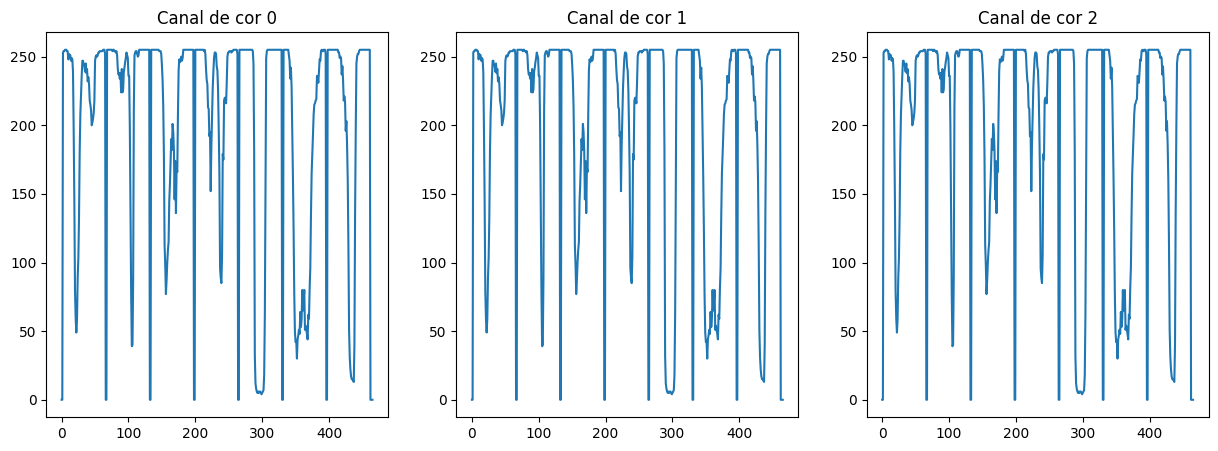

In [43]:
import matplotlib.pyplot as plt

first_key = list(dict1.keys())[0] # obtém a primeira chave do dicionário
first_image = dict1[first_key][24] # obtém a primeira imagem da lista associada à primeira chave

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax[i].plot(first_image[:, i])
    ax[i].set_title(f'Canal de cor {i}')

plt.show()


In [19]:
# EExp 2, beta = 4
NOME_EXPERIMENTO = 'juliana-betaH-B-4_new'
# format NOME_EXPERIMENTO to args_experimento
args_experimento =  ' -d chairs -l betaH --betaH-B 4 --lr 0.001 -b 64 -e 1'
args_viz = ' all --is-show-loss'
dict2 = experimento(NOME_EXPERIMENTO, args_experimento, args_viz)



C:\Users\atoma\AppData\Local\Temp\ipykernel_25424\1060282560.py:46: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.encoder = encoder(img_size, self.latent_dim)
C:\Users\atoma\AppData\Local\Temp\ipykernel_25424\1060282560.py:47: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.decoder = decoder(img_size, self.latent_dim)


Num parameters in model: 502005


Selected idcs: [57767, 15315, 981, 11880, 76313, 4577, 11001, 12900, 46482, 31039, 2284, 4038, 2076, 45362, 84976, 81694, 63471, 80716, 60758, 19471, 11965, 23998, 14996, 1916, 65940, 63799, 32745, 8462, 70921, 61066, 8987, 78835, 11656, 67507, 75891, 6024, 35335, 72932, 8267, 84493, 39639, 63050]


### Experimentos com beta-B

In [20]:
# EExp 2, beta = 4
NOME_EXPERIMENTO = 'ademir-betaH-B-4_new'
# format NOME_EXPERIMENTO to args_experimento
args_experimento =  ' -d fashion -l betaH --betaH-B 4 --lr 0.001 -b 64 -e 1'
args_viz = ' all --is-show-loss'
dict3 = experimento(NOME_EXPERIMENTO, args_experimento, args_viz)

C:\Users\atoma\AppData\Local\Temp\ipykernel_25424\1060282560.py:46: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.encoder = encoder(img_size, self.latent_dim)
C:\Users\atoma\AppData\Local\Temp\ipykernel_25424\1060282560.py:47: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.decoder = decoder(img_size, self.latent_dim)


Num parameters in model: 469173


Selected idcs: [50997, 28883, 7657, 490, 5940, 59701, 52887, 38156, 2288, 44011, 45422, 5500, 6450, 50232, 23241, 15519, 1142, 2019, 51693, 1038, 22681, 42488, 40847, 31735, 40358, 30379, 9735, 5982, 11999, 46754, 7498, 55400, 958, 32970, 31899, 57702, 16372, 4231, 43729, 35460, 59789, 30533]
